In [1]:
import os
os.chdir(path='../../')
import warnings
warnings.filterwarnings('ignore') 
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
import scib

import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import STForte.helper as stfhelper
from STForte import STGraph
from STForte.helper import mclust_R
stfhelper.init_mclust_R()

sc.set_figure_params(dpi=120, transparent=True, dpi_save=400, frameon=False, vector_friendly=False, format="pdf", fontsize=24)
trial_name = "trial-DLPFC/multi_slides/"
plot_dir = f"./{trial_name}/plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]
# palette = px.colors.qualitative.Plotly
palette = ['#EF553B','#00CC96','#AB63FA','#636EFA','#FF6692','#FFA15A','#19D3F3']


/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/lightning_fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning_fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/lightning_fabric/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/pytorch_lightning/__init__.py:45: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Im

In [2]:

# adata = sc.read_h5ad("/home/wcx99075523/Experiments/stforte/trial-DLPFC-pca/multi_slides/outputs/stforte_multi_507_510.h5ad")
# adata = sc.read_h5ad("/home/wcx99075523/Experiments/stforte/trial-DLPFC-pca/multi_slides/outputs/stforte_multi_669_672.h5ad")
adata = sc.read_h5ad(f"{trial_name}/outputs/stforte_multi_673_676.h5ad")
data_name = ['151673','151674','151675','151676']
# data_name = ['151669','151670','151671','151672']
# data_name = ['151507','151508','151509','151510']
adata_multi = dict()
for i in adata.obs['section_id'].cat.categories:
    temp_adata = adata[adata.obs['section_id']==i,]
    temp_adata.uns = adata.uns[data_name[int(i)]]
    adata_multi[data_name[int(i)]] = temp_adata

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
# adata_each = dict()
# adata = sc.read_h5ad("/home/wcx99075523/Experiments/stforte/trial-DLPFC-pca/multi_slides/outputs/sp_multi.h5ad")
# for i in adata.obs['section_id'].cat.categories:
#     temp_adata = adata[adata.obs['section_id']==i,]
#     temp_adata.uns = adata.uns[data_name[int(i)]]
#     adata_each[data_name[int(i)]] = temp_adata

In [4]:
adata_each = dict()
for name in data_name:
    adata_each[name] = sc.read_h5ad(f"/home/wcx99075523/Experiments/STForte/trial-DLPFC-pca/trial_all/outputs/sp_{name}.h5ad")

In [5]:
for name in data_name:
    temp_adata = adata_multi[name]
    d = temp_adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
    stgraph = STGraph.graphFromAnndata(
        adata=temp_adata,
        d=d,
        )
    stgraph.node_attr = temp_adata.obsm['STForte_ATTR']
    stgraph.padding(reconstruct_knn=True, reconstruct_k=18)
    node_fp = stgraph.feature_propagate()
    adata_each[name].obsm['Combine_COMB'] = np.concatenate([adata_each[name].obsm['SP_COMB'], node_fp], axis=1)

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


d-based initialize:   0%|          | 0/3639 [00:00<?, ?it/s]

brute-force knn initialize:   0%|          | 0/14201 [00:00<?, ?it/s]

FP


d-based initialize:   0%|          | 0/3673 [00:00<?, ?it/s]

brute-force knn initialize:   0%|          | 0/14302 [00:00<?, ?it/s]

FP


d-based initialize:   0%|          | 0/3592 [00:00<?, ?it/s]

brute-force knn initialize:   0%|          | 0/13973 [00:00<?, ?it/s]

FP


d-based initialize:   0%|          | 0/3460 [00:00<?, ?it/s]

brute-force knn initialize:   0%|          | 0/13486 [00:00<?, ?it/s]

FP


In [6]:
for name in data_name:
    adata_multi[name].obsm['Combine'] = adata_each[name].obsm['Combine_COMB'][adata_each[name].obs['spot_instance']=="Observed"]

In [7]:
for name in data_name:
    stfhelper.annotation_propagate(adata_each[name], "mclust_STForte_COMB", adata_multi[name], latent_embed="SP_TOPO")

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/s

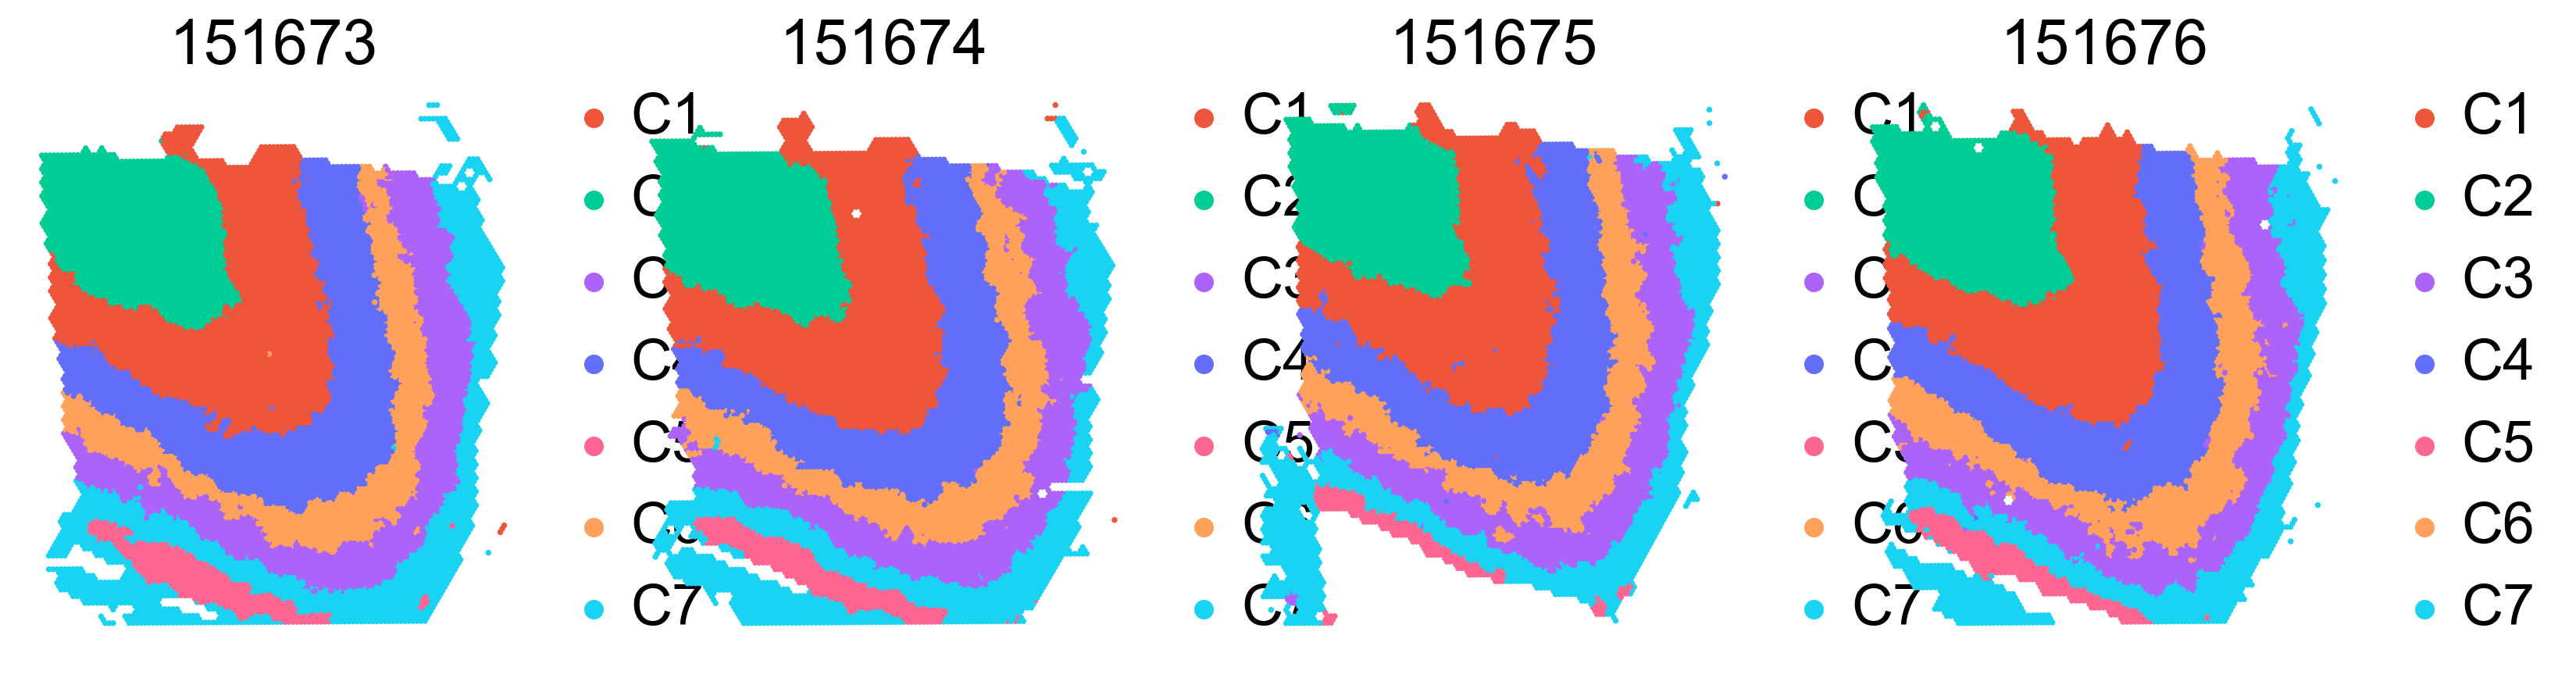

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
c=0
for name in data_name:
    sc.pl.embedding(adata_each[name], basis="spatial", color="mclust_STForte_COMB_with_padding",s=20, ax=axs[c],
                        show=False, title=name, palette=palette) # legend_loc="on data") 
    c+=1
fig.savefig(f"{trial_name}/plots/673_676_padding.pdf")

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/s

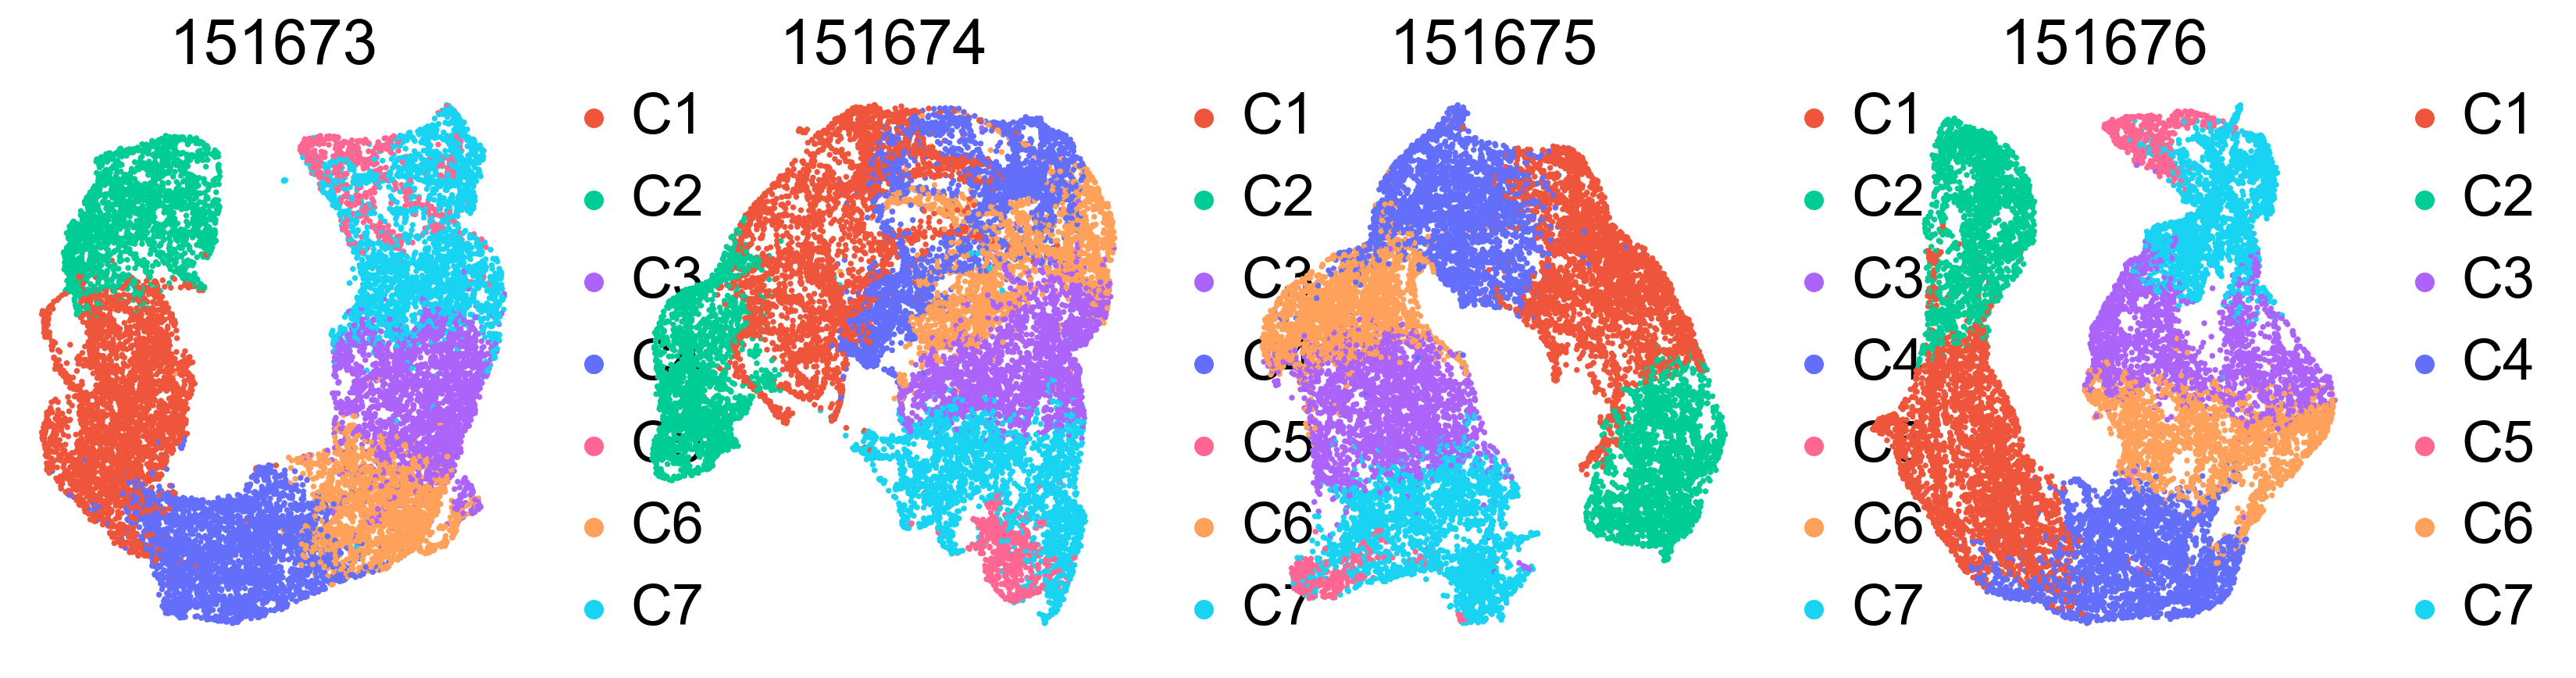

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
c=0
for name in data_name:
    sc.pp.neighbors(adata_each[name], use_rep="SP_ATTR_FP")
    sc.tl.umap(adata_each[name])
    sc.pl.embedding(adata_each[name], basis="X_umap", color="mclust_STForte_COMB_with_padding",s=20, ax=axs[c],
                        show=False, title=name, palette=palette) # legend_loc="on data") 
    c+=1
fig.savefig(f"{trial_name}/plots/673_676_padding_umap.pdf")

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/s

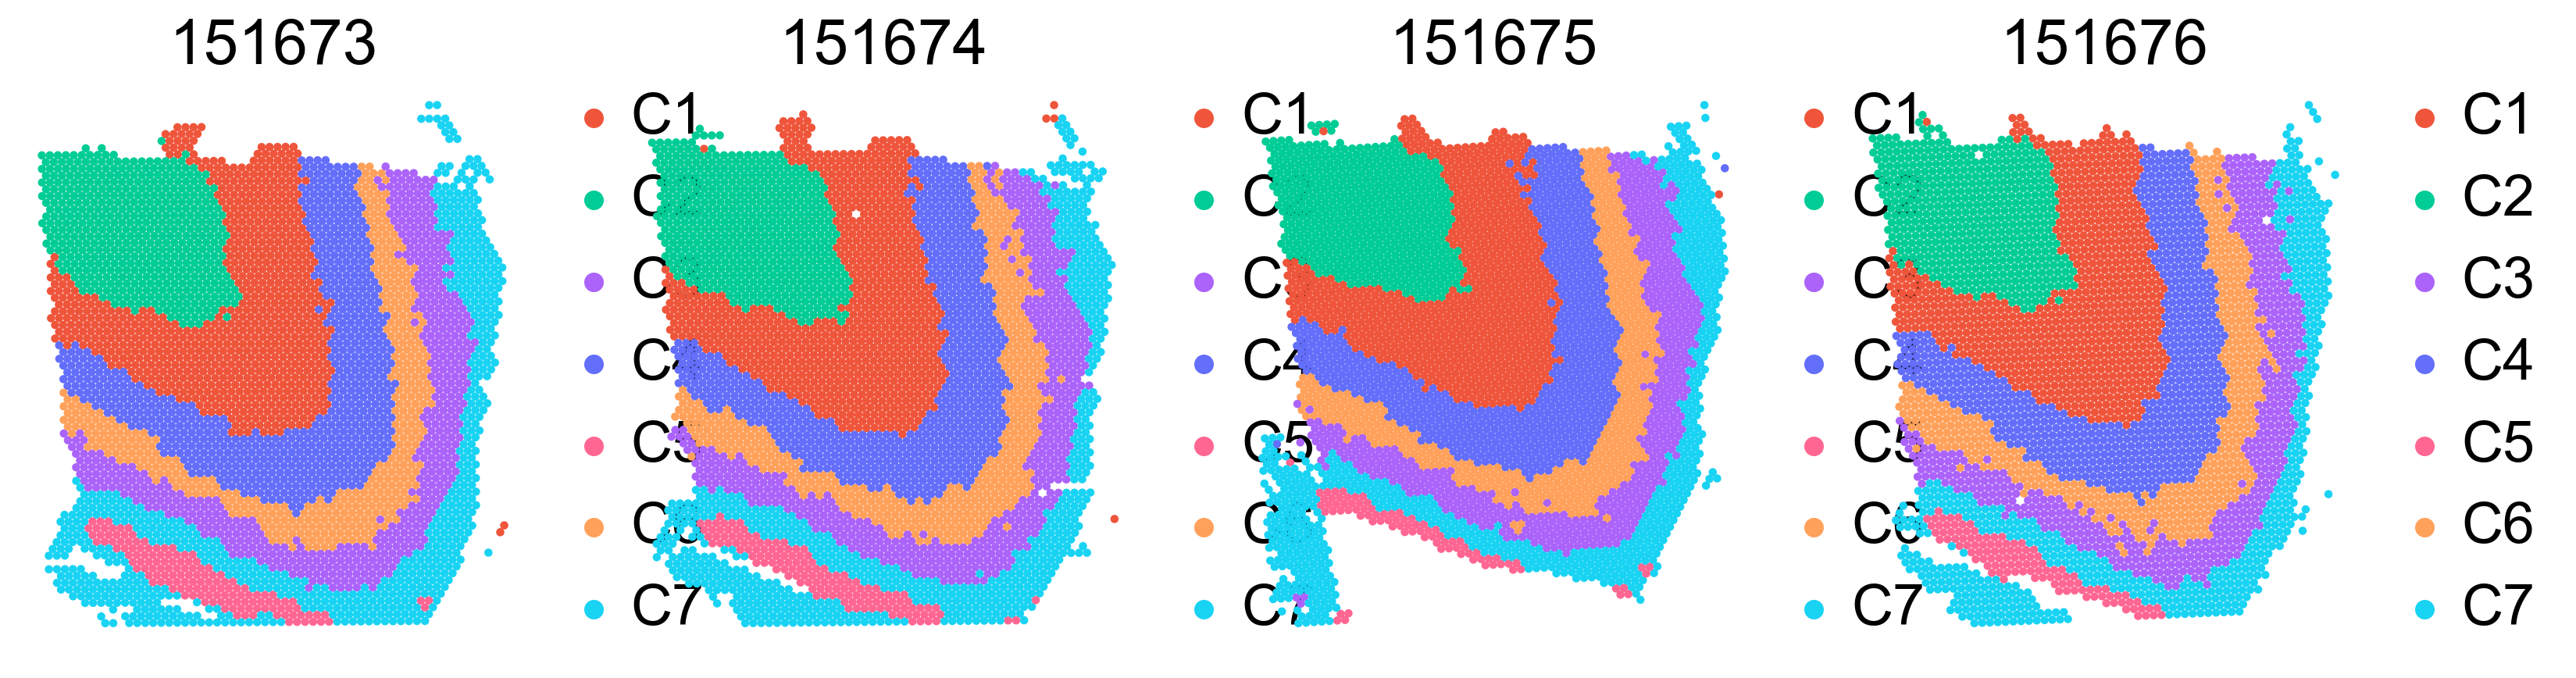

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
c=0
for name in data_name:
    sc.pl.embedding(adata_multi[name], basis="spatial", color="mclust_STForte_COMB",s=40, ax=axs[c],
                        show=False, title=name, palette=palette) # legend_loc="on data") 
    c+=1
fig.savefig(f"{trial_name}/plots/673_676.pdf")

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/s

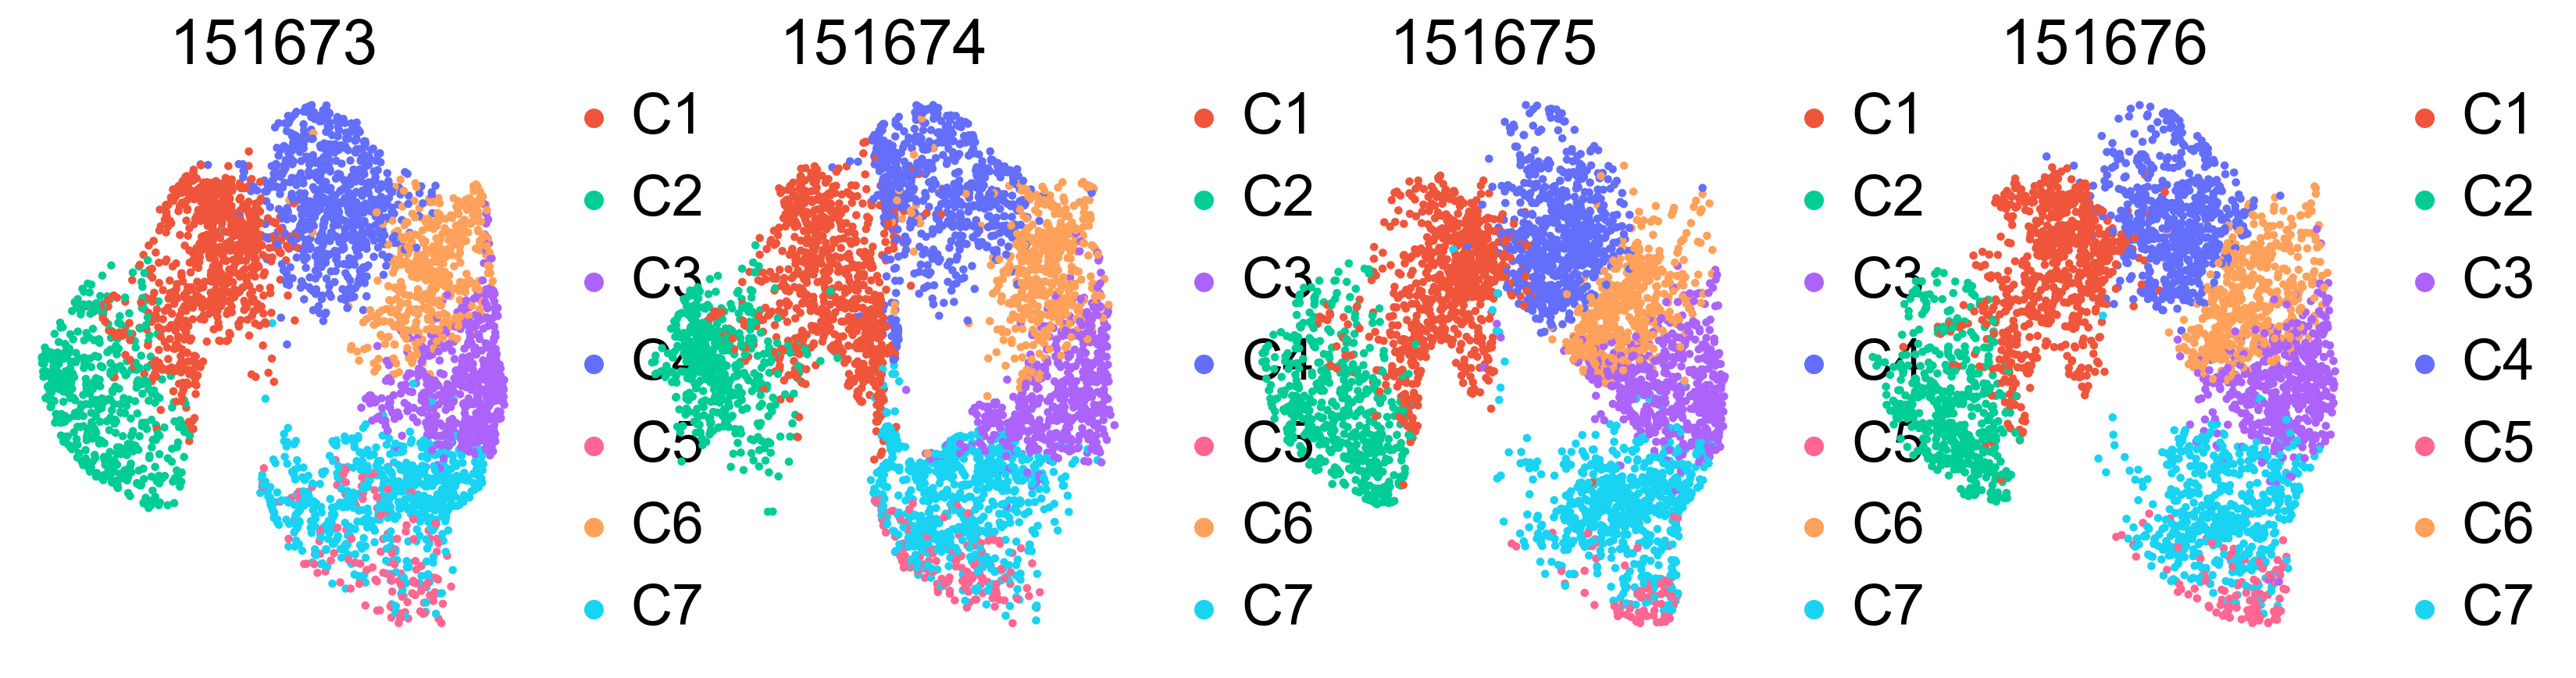

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
c=0
for name in data_name:
    sc.pl.embedding(adata_multi[name], basis="UMAP_STForte_ATTR", color="mclust_STForte_COMB",s=40, ax=axs[c],
                        show=False, title=name, palette=palette) # legend_loc="on data") 
    c+=1
fig.savefig(f"{trial_name}/plots/673_676_umap.pdf")

In [12]:
adata_pad = sc.concat(list(adata_each.values()),axis=0)
adata_pad

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 55962 × 300
    obs: 'spot_instance', 'mclust_STForte_COMB_with_padding'
    obsm: 'SP_ATTR_FP', 'SP_COMB', 'SP_TOPO', 'spatial', 'Combine_COMB', 'X_umap'

In [13]:
adata_pad.obs['section_id'] = [item for l in ([i]*len(d) for i, d in zip(range(4),adata_each.values())) for item in l]
adata_pad

AnnData object with n_obs × n_vars = 55962 × 300
    obs: 'spot_instance', 'mclust_STForte_COMB_with_padding', 'section_id'
    obsm: 'SP_ATTR_FP', 'SP_COMB', 'SP_TOPO', 'spatial', 'Combine_COMB', 'X_umap'

In [14]:
adata_ori = sc.concat(list(adata_multi.values()),axis=0)
adata_ori

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 14364 × 24155
    obs: 'in_tissue', 'array_row', 'array_col', 'spatialLIBD', 'section_id', 'mclust_STForte_ATTR', 'mclust_STForte_COMB', 'mclust_STForte_TOPO'
    obsm: 'STForte_ATTR', 'STForte_COMB', 'STForte_TOPO', 'UMAP_STForte_ATTR', 'UMAP_STForte_COMB', 'UMAP_STForte_TOPO', 'UMAP_before', 'X_pca', 'spatial', 'Combine'
    layers: 'log1p'

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


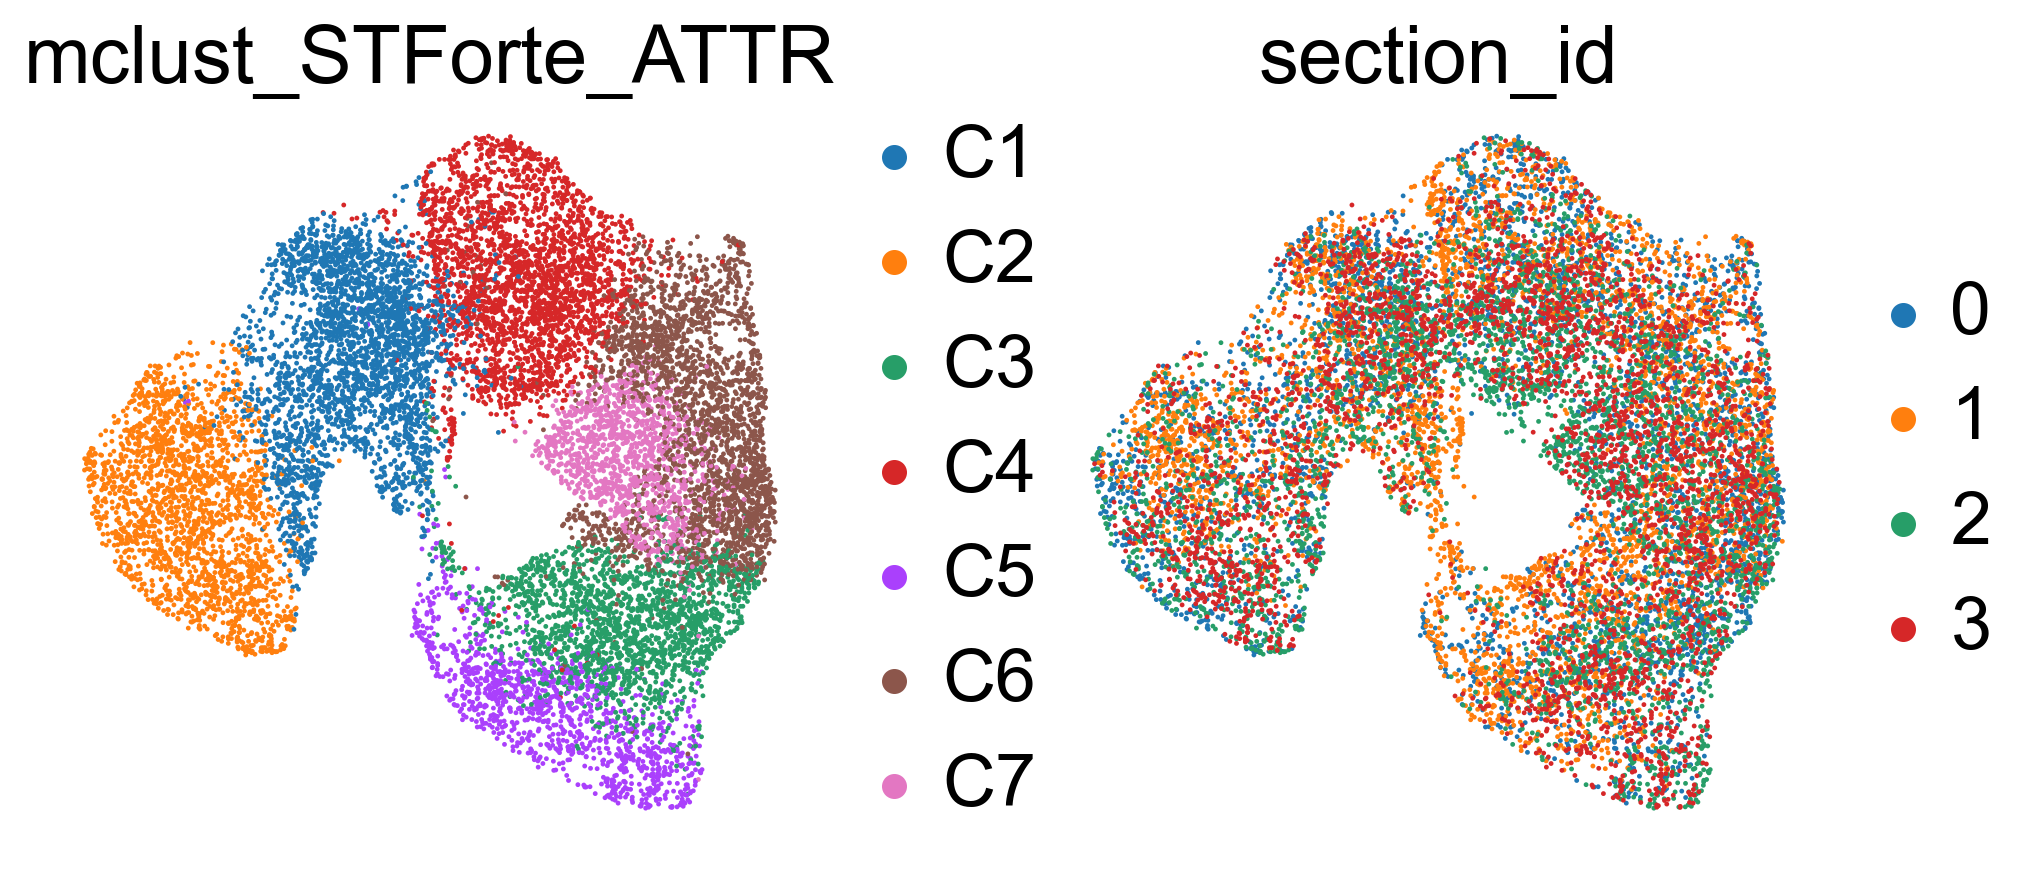

In [15]:
sc.pl.embedding(adata=adata_ori, basis='UMAP_STForte_ATTR',  color=['mclust_STForte_ATTR','section_id'])

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


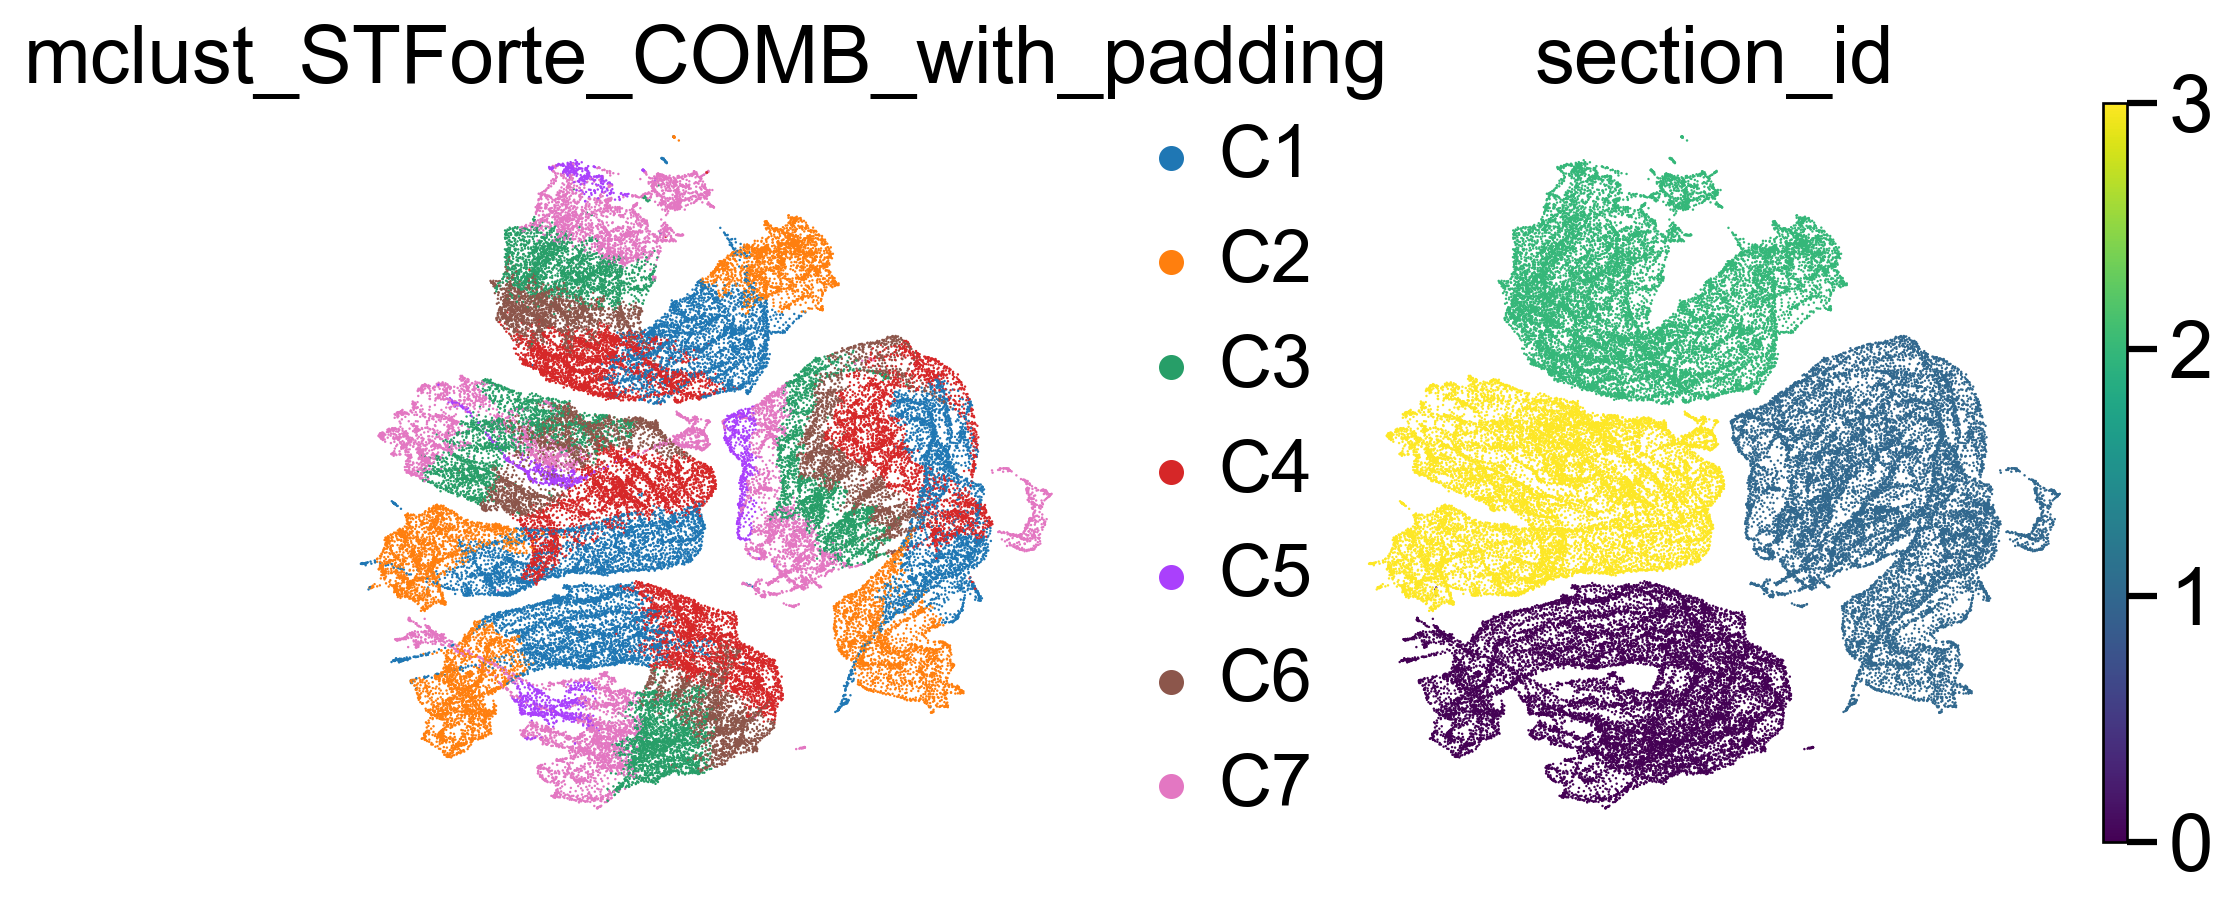

In [16]:
sc.pp.neighbors(adata_pad, use_rep="SP_COMB")
sc.tl.umap(adata_pad)
sc.pl.embedding(adata=adata_pad, basis='X_umap',  color=['mclust_STForte_COMB_with_padding','section_id'])

In [17]:
adata_pad.write(f"{trial_name}/outputs/adata_673_676_pad.h5ad")